In [3]:
import matplotlib.pyplot as plt
import numpy as np
import openfermion as of
from itertools import product
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy as sp
from pyscf import gto, scf, ao2mo, mp, tdscf, dft
from pyscf import sftda
from openfermionpyscf import generate_molecular_hamiltonian
import glob

## Generalized Hartree-Fock

In [4]:
mol = gto.M(
    atom = 'H 0 0 0; H 0 0 3',
    basis = '6-31G',
    spin = 0,
    charge = 0
)

mf = dft.UKS(mol)
mf.xc = 'svwn'
mf.kernel()

mo_coeff = mf.mo_coeff
# print("MO Coefficients:\n", mo_coeff)

multiplicity = 1
molecular_hamiltonian = generate_molecular_hamiltonian(
    mol.atom, mol.basis, multiplicity, mol.charge
)

jw_hamiltonian = of.jordan_wigner(of.get_fermion_operator(molecular_hamiltonian))
# print("JW Hamiltonian:\n", jw_hamiltonian)

n_qubits = mol.nao * 2

converged SCF energy = -0.90760072478498  <S^2> = -8.8817842e-16  2S+1 = 1


In [5]:
n_electron = 2
n_excited_state = 12
# p = n_excited_state + 1
p = n_excited_state

valid_indices = []
for bits in product('01', repeat= n_qubits):
    if bits.count('1') == n_electron:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))
        # print(int(binary_str,2))

In [6]:
sparse_hamiltonian = of.get_sparse_operator(jw_hamiltonian)
H = sparse_hamiltonian[np.ix_(valid_indices, valid_indices)].toarray()
H_eigvals, H_eigvecs = sp.linalg.eigh(H)
print(f"H4 eigenvalues", H_eigvals[:])
H_dim = len(H)
print(H_dim)

H4 eigenvalues [-0.99745483 -0.99597969 -0.99597969 -0.99597969 -0.60732453 -0.60480046
 -0.04635358 -0.04635358 -0.04635358 -0.03821833 -0.03821833 -0.03821833
 -0.03435989 -0.02918123  0.25661562  0.25661562  0.25661562  0.26672639
  0.26672639  0.26672639  0.5013429   0.50220759  0.92921256  0.93550011
  0.93550011  0.93550011  1.52755023  1.54375384]
28


In [7]:
mftd = mf.TDA()
mftd.nstates = n_excited_state//2-1 # -1 for length>3....only for H2!!!
mftd.kernel()

Excited State energies (eV)
[ 9.01194726 22.9632403  25.86179012 26.17372643 29.12049764]


(array([0.33118296, 0.84388352, 0.95040327, 0.96186671, 1.07015856]),
 [((array([[ 6.98840827e-01,  5.55683758e-10, -1.07803053e-01]]),
    array([[ 6.98840827e-01,  5.55467822e-10, -1.07803053e-01]])),
   (0, 0)),
  ((array([[-4.44828449e-11, -7.07106782e-01,  8.95033506e-10]]),
    array([[ 4.46508311e-11,  7.07106781e-01, -8.95360249e-10]])),
   (0, 0)),
  ((array([[-2.33291731e-02,  8.96935453e-10,  7.06721834e-01]]),
    array([[ 2.33291732e-02, -8.95424447e-10, -7.06721833e-01]])),
   (0, 0)),
  ((array([[9.47840125e-11, 7.07106781e-01, 4.25770288e-09]]),
    array([[9.47394835e-11, 7.07106782e-01, 4.25921357e-09]])),
   (0, 0)),
  ((array([[-1.07803053e-01,  4.22327335e-09, -6.98840827e-01]]),
    array([[-1.07803053e-01,  4.22297605e-09, -6.98840828e-01]])),
   (0, 0))])

In [8]:
mftd_sf_up = sftda.TDA_SF(mf)
mftd_sf_up.nstates = n_excited_state//4 # the number of excited states
mftd_sf_up.extype = 0 # 0 for spin flip up excited energies
# the spin sample points in multicollinear approach, which
# can be increased by users.
mftd_sf_up.collinear_samples=1
mftd_sf_up.max_space  = 1
mftd_sf_up.kernel()

mftd_sf_dn = sftda.uks_sf.TDA_SF(mf)
mftd_sf_dn.nstates = n_excited_state//4 # the number of excited states
mftd_sf_dn.extype = 1 # 1 for spin flip down excited energies
mftd_sf_dn.collinear_samples=1
mftd_sf_dn.max_space  = 1
mftd_sf_dn.kernel()

1


<class 'pyscf.sftda.uhf_sf.TDA_SF'> does not have attributes  max_space


Excited State energies (eV)
[-1.10778667 22.9632403  25.86179012]
1


<class 'pyscf.sftda.uks_sf.TDA_SF'> does not have attributes  max_space


Excited State energies (eV)
[-1.10778667 22.96324031 25.86179012]


(array([-0.04071041,  0.84388352,  0.95040327]),
 [((0, array([[ 9.99455601e-01, -2.12728784e-11,  3.29924330e-02]])), (0, 0)),
  ((0, array([[ 6.30928899e-11,  1.00000000e+00, -1.26652266e-09]])), (0, 0)),
  ((0, array([[-3.29924330e-02,  1.26791470e-09,  9.99455601e-01]])), (0, 0))])

In [9]:
def sf_up_state(ith, valid_indices, xy, n_electron, n_qubits):
    HF_index = 0
    for i in range(n_electron):
        HF_index += 2**(n_qubits-i-1)

    X_spin_up = xy[ith][0][0]

    n_occ_state = n_electron//2 # only can do the even case
    n_vir_state = n_qubits//2 - n_occ_state

    state= np.zeros(2**n_qubits)
    for occ_index in range(n_occ_state):
        for vir_index in range(n_vir_state):
                spin_up_excited_state = np.zeros(2**n_qubits)

                spin_up_excited_index = HF_index - 2**(n_qubits-occ_index*2-1) + 2**(n_qubits-2-n_electron-vir_index*2)

                spin_up_excited_state[spin_up_excited_index] = 1

                state += X_spin_up[occ_index][vir_index] * spin_up_excited_state

    state = state[valid_indices]
    
    return state

In [10]:
def sf_dn_state(ith, valid_indices, xy, n_electron, n_qubits):
    HF_index = 0
    for i in range(n_electron):
        HF_index += 2**(n_qubits-i-1)

    X_spin_dn = xy[ith][0][1] # tdhf.xy[excited_state_index][X_or_Y][spin][occupied_MO][virtual_MO]

    n_occ_state = n_electron//2 # only can do the even case
    n_vir_state = n_qubits//2 - n_occ_state

    state= np.zeros(2**n_qubits)
    for occ_index in range(n_occ_state):
        for vir_index in range(n_vir_state):
                spin_dn_excited_state = np.zeros(2**n_qubits)

                spin_dn_excited_index = HF_index - 2**(n_qubits-occ_index*2-2) + 2**(n_qubits-1-n_electron-vir_index*2)

                spin_dn_excited_state[spin_dn_excited_index] = 1

                state += X_spin_dn[occ_index][vir_index] * spin_dn_excited_state

    state = state[valid_indices]
    
    return state

In [11]:
def spin_conserved_state(ith, valid_indices, xy, n_electron, n_qubits):
    # HF_state = np.zeros(2**n_qubits)
    HF_index = 0
    for i in range(n_electron):
        HF_index += 2**(n_qubits-i-1)
    # HF_state[HF_index] = 1

    # HF_state = HF_state[valid_indices]
    X_spin_up = xy[ith][0][0] # tdhf.xy[excited_state_index][X_or_Y][spin][occupied_MO][virtual_MO]
    X_spin_dn = xy[ith][0][1]

    n_occ_state = n_electron//2 # only can do the even case
    n_vir_state = n_qubits//2 - n_occ_state

    state= np.zeros(2**n_qubits)
    for occ_index in range(n_occ_state):
        for vir_index in range(n_vir_state):
                spin_up_excited_state = np.zeros(2**n_qubits)
                spin_dn_excited_state = np.zeros(2**n_qubits)

                spin_up_excited_index = HF_index - 2**(n_qubits-occ_index*2-1) + 2**(n_qubits-1-n_electron-vir_index*2)
                spin_dn_excited_index = HF_index - 2**(n_qubits-occ_index*2-2) + 2**(n_qubits-2-n_electron-vir_index*2)

                # print(occ_index, vir_index)
                # print(spin_up_excited_index)
                # print(spin_dn_excited_index)

                spin_up_excited_state[spin_up_excited_index] = 1
                spin_dn_excited_state[spin_dn_excited_index] = 1

                state += X_spin_up[occ_index][vir_index] * spin_up_excited_state + X_spin_dn[occ_index][vir_index] * spin_dn_excited_state

    state = state[valid_indices]
    # state = state/sp.linalg.norm(state)
    
    return state

def TDA_states_solver(n_excited_state, valid_indices, n_electron, n_qubits, mf, td, td_sf_up, td_sf_dn):

    # Notice!! The order of eigvals and eigvecs are not consistent!

    eigvecs = []

    HF_state = np.zeros(2**n_qubits)
    HF_index = 0
    for i in range(n_electron):
        HF_index += 2**(n_qubits-i-1)
    HF_state[HF_index] = 1
    HF_state = HF_state[valid_indices]

    eigvecs.append(HF_state)
    for i in range(n_excited_state//2-1): # -1 for length>3....only for H2!!!
        eigvecs.append(spin_conserved_state(i, valid_indices, td.xy, n_electron, n_qubits))

    eigvals = [mf.energy_tot()]
    for excited_energy in td.e:
        eigvals.append(mf.energy_tot() + excited_energy)

    for i in range(n_excited_state//4):
        eigvecs.append(sf_up_state(i, valid_indices, td_sf_up.xy, n_electron, n_qubits))

    for excited_energy in td_sf_up.e:
        eigvals.append(mf.energy_tot() + excited_energy)

    for i in range(n_excited_state//4):
        eigvecs.append(sf_dn_state(i, valid_indices, td_sf_dn.xy, n_electron, n_qubits))
    eigvecs = np.array(eigvecs).T

    for excited_energy in td_sf_dn.e:
        eigvals.append(mf.energy_tot() + excited_energy)
    
    eigvals = np.sort(eigvals)
    return eigvals, eigvecs


In [12]:
TDA_eigvals, TDA_eigvecs = TDA_states_solver(n_excited_state, valid_indices, n_electron, n_qubits, mf, mftd, mftd_sf_up, mftd_sf_dn)

In [13]:
def gram_schmidt(vectors):
    """
    使用 Gram-Schmidt 過程將一組向量正交化。
    :param vectors: shape (n, m) 的 numpy array，n 是向量數量，m 是維度
    :return: 正交化後的向量矩陣
    """
    orthogonal_vectors = []
    for v in vectors.T:
        w = v.copy()
        for u in orthogonal_vectors:
            w -= np.dot(u, v) / np.dot(u, u) * u
        if np.linalg.norm(w) > 1e-10:  # 避免數值誤差導致零向量
            orthogonal_vectors.append(w / np.linalg.norm(w))
    return np.array(orthogonal_vectors).T

TDA_eigvecs = gram_schmidt(TDA_eigvecs)

In [14]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = np.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = np.zeros((dim, dim), dtype=np.complex64)
    for d in range(degeneracy_dim):
        O += np.outer(degeneracy_eigvecs[:, d], np.conj(degeneracy_eigvecs[:, d]))
    Q = np.eye(dim) - O
    M = alpha * O + Q @ (E * np.eye(dim) - H) @ Q + gamma * 1j * np.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = sp.linalg.inv(M)

    Rij = np.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return np.real(Hij + Rij - E * np.eye(degeneracy_dim))

In [15]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = np.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = np.zeros((dim, dim), dtype=np.complex64)
    for d in range(degeneracy_dim):
        O += np.outer(degeneracy_eigvecs[:, d], np.conj(degeneracy_eigvecs[:, d]))
    Q = np.eye(dim) - O
    M = alpha * O + Q @ (E * np.eye(dim) - H) @ Q + gamma * 1j * np.eye(dim)

    N = sp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = sp.linalg.eigh(M)
    M_eigvals_inv = np.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ np.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = np.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return np.real(Hij + Rij - E * np.eye(degeneracy_dim))

In [16]:
def Schur_complement_norm(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = np.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = np.zeros((dim, dim), dtype=np.complex64)
    for d in range(degeneracy_dim):
        O += np.outer(degeneracy_eigvecs[:, d], np.conj(degeneracy_eigvecs[:, d]))
    Q = np.eye(dim) - O
    M = alpha * O + Q @ (E * np.eye(dim) - H) @ Q + gamma * 1j * np.eye(dim)

    N = sp.linalg.norm(M)

    return(N)

In [17]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = np.zeros((dim, dim), dtype=np.complex64)
    for d in range(degeneracy_dim):
        O += np.outer(degeneracy_eigvecs[:, d], np.conj(degeneracy_eigvecs[:, d]))
    Q = np.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = sp.linalg.eigh(QHQ)

    return spectrum

In [18]:
degeneracy_idx = [0, p-1]
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H, init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim)

## Eigenbranches (error $ = 10^{-8}$)

In [19]:
kappa = 400
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = np.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [20]:
Xlim = [-1.25, 0.5]
N_plot = 5000
Energy = np.linspace(Xlim[0], Xlim[1], N_plot)

In [21]:
Schur_complement_norm(H=H, E=H_eigvals[0], init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim)

7.085597693640058

In [22]:
def sort_eigen_by_vectors(Schur, vectors):

    eigvals, eigvecs = np.linalg.eigh(Schur)

    eigvecs = eigvecs.T
    
    n = len(vectors)
    sorted_eigvals = np.zeros(n)
    sorted_eigvecs = np.zeros((n, n))
    for i in range(n):
        v = vectors[:, i]
        # 找到最匹配的特徵向量
        similarities = np.abs(eigvecs @ v)  # 計算投影的絕對值
        # print(np.round(similarities,2))
        best_match_idx = np.argmax(similarities)  # 找到最匹配的特徵向量索引
        sorted_eigvals[i] = eigvals[best_match_idx]  # 依照 v 的順序存入特徵值
        sorted_eigvecs[:, i] = eigvecs[best_match_idx]
    return sorted_eigvals, sorted_eigvecs

In [23]:
Schur = Schur_complement_qsp(H=H, E=Xlim[0], init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim, poly=poly, kappa=kappa)
_, sub_eigvals_ref = sp.linalg.eigh(Schur)
Last_Overlap_Eigenbranches = []
for i, En in enumerate(Energy):
    if i % 100 == 0:
        print('iter', i)
    Schur = Schur_complement_qsp(H=H, E=En, init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim, poly=poly, kappa=kappa)
    sub_eigvals, sub_eigvals_ref = sort_eigen_by_vectors(Schur, sub_eigvals_ref)
    Last_Overlap_Eigenbranches.append(sub_eigvals)
Last_Overlap_Eigenbranches = np.array(Last_Overlap_Eigenbranches).T

iter 0
iter 100
iter 200
iter 300
iter 400
iter 500
iter 600
iter 700
iter 800
iter 900
iter 1000
iter 1100
iter 1200
iter 1300
iter 1400
iter 1500
iter 1600
iter 1700
iter 1800
iter 1900
iter 2000
iter 2100
iter 2200
iter 2300
iter 2400
iter 2500
iter 2600
iter 2700
iter 2800
iter 2900
iter 3000
iter 3100
iter 3200
iter 3300
iter 3400
iter 3500
iter 3600
iter 3700
iter 3800
iter 3900
iter 4000
iter 4100
iter 4200
iter 4300
iter 4400
iter 4500
iter 4600
iter 4700
iter 4800
iter 4900


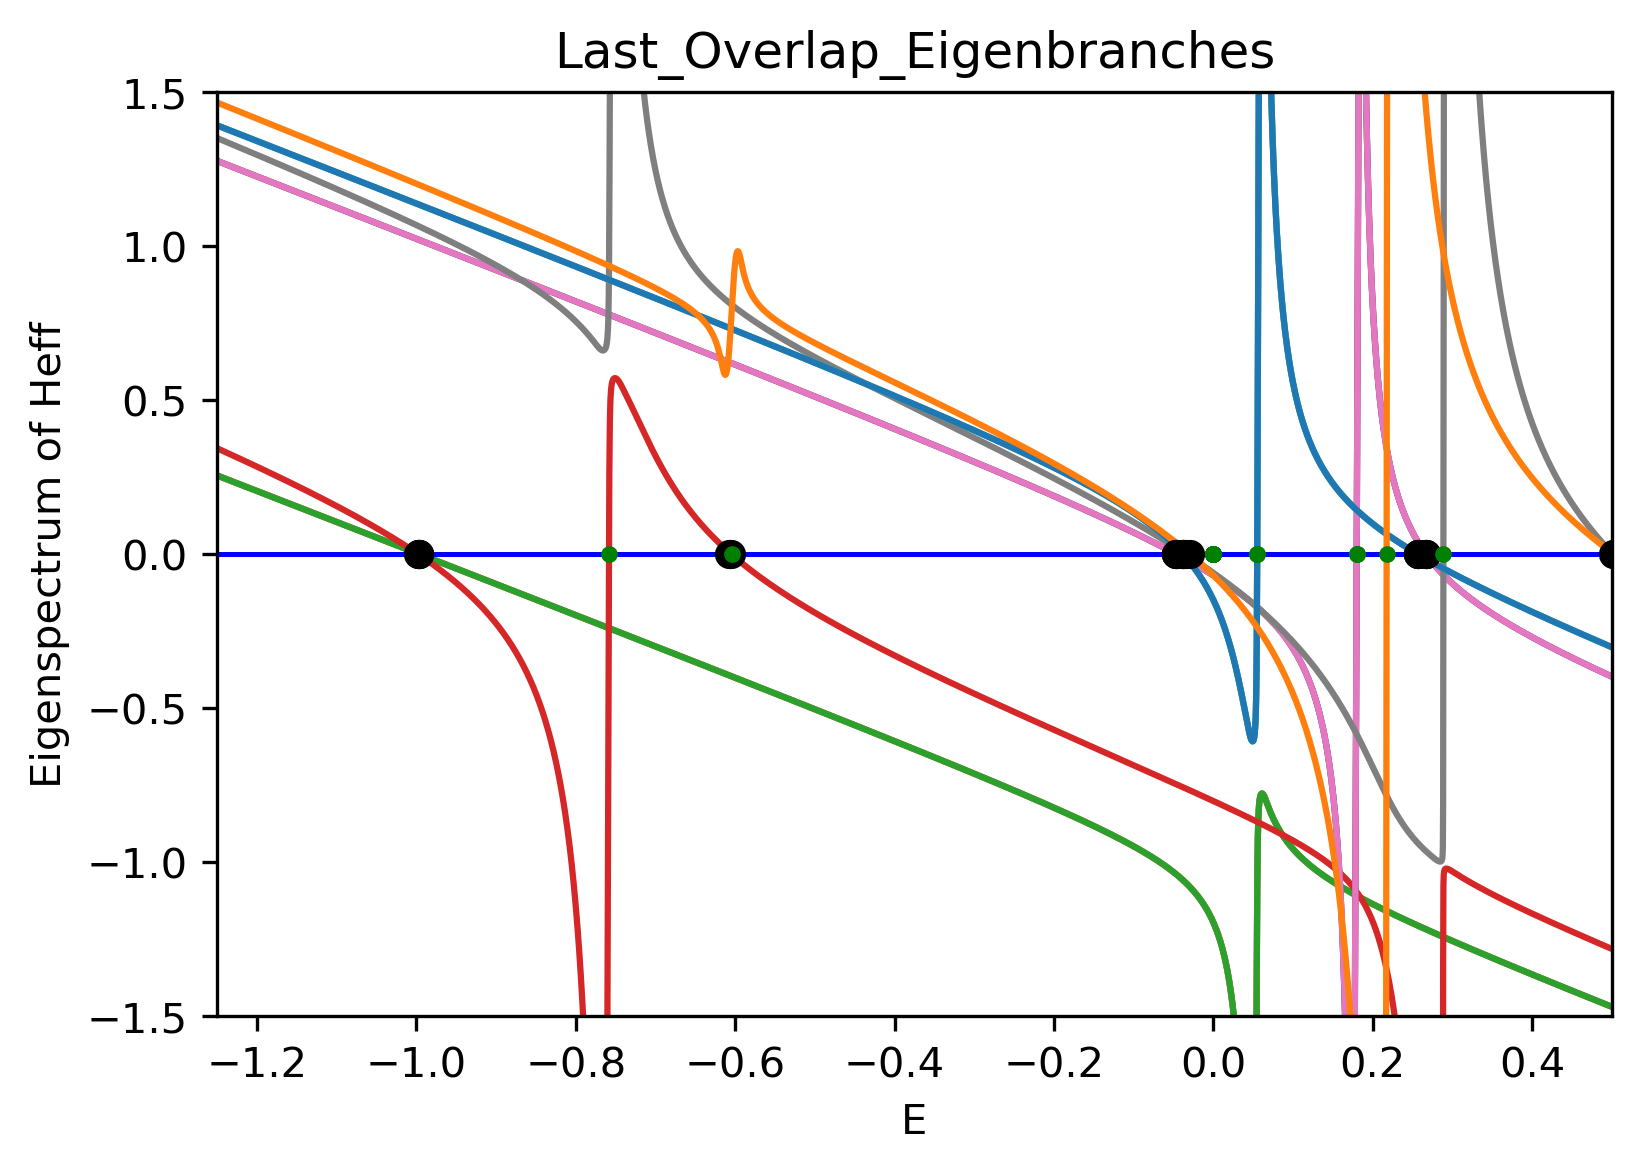

In [24]:
plt.figure(figsize=(6, 4), dpi=300) 
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(-8, -7.6)
plt.ylim(-1.5, 1.5)

for Last_Overlap_Eigenbranch in Last_Overlap_Eigenbranches:
    plt.plot(Energy, Last_Overlap_Eigenbranch, linewidth=1.5)


plt.axhline(y=0, color='blue', linewidth=1.2)

plt.plot(H_eigvals, np.zeros_like(H_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, np.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)
plt.title('Last_Overlap_Eigenbranches')

plt.show()

## Generalized Hartree-Fock

In [37]:
mf = scf.GHF(mol)
ehf = mf.kernel()

converged SCF energy = -0.815591772270659  <S^2> = 2.6645353e-15  2S+1 = 1


## GCCSD

In [38]:
mycc = mf.CCSD()
ecc, t1, t2 = mycc.kernel()

E(GCCSD) = -0.9974548300824937  E_corr = -0.1818630578118347


## EOM-GCCSD and excited states

In [39]:
eom_e, eom_v = mycc.eeccsd(nroots=n_excited_state)

In [28]:
CCSD_eigvals = [ehf + ecc]
for e in eom_e:
    CCSD_eigvals.append(ehf + ecc + e)

In [29]:
print("E_CCSD - E_exact:\n", CCSD_eigvals-H_eigvals[:13])

E_CCSD - E_exact:
 [ 7.51620988e-14  9.51461132e-14  9.67004254e-14  9.44799794e-14
 -9.91429161e-14 -1.22124533e-13  8.32667268e-16 -1.09634524e-15
 -1.18655086e-15 -2.84286483e-14 -2.89421265e-14 -2.85813040e-14
  3.10862447e-15]


## Binary search

In [30]:
def singularity_detect_overlap_binary_search_solver(Schur_complement, x0, n_bands, E_cutoff=10**(-error), max_iter=100):
    
    solved_eigvals = []

    Schur = Schur_complement(x0)
    _, v0 = np.linalg.eigh(Schur)

    def f(x, n_bands_idx):
        Schur = Schur_complement(x)
        sub_eigvals, sub_eigvecs = np.linalg.eigh(Schur)
        v_ref = v0[:, n_bands_idx]
        sub_eigvecs = sub_eigvecs.T
        similarities = np.abs(sub_eigvecs @ v_ref)
        best_match_idx = np.argmax(similarities)
        return sub_eigvals[best_match_idx]
    
    def second_largest_index(v):
        sorted_indices = np.argsort(v)  # 取得排序後的索引（由小到大）
        return sorted_indices[-2]  # 倒數第二個即為第二大值的索引
    
    def f_second(x, n_bands_idx):
        Schur = Schur_complement(x)
        sub_eigvals, sub_eigvecs = np.linalg.eigh(Schur)
        v_ref = v0[:, n_bands_idx]
        sub_eigvecs = sub_eigvecs.T
        similarities = np.abs(sub_eigvecs @ v_ref)
        second_match_idx = second_largest_index(similarities)
        return sub_eigvals[second_match_idx]

    for n_bands_idx in range(n_bands):
        conveged = False
        print(f"Start searching the {n_bands_idx}th band.")
        xn = x0
        fn = f(xn, n_bands_idx)
        
        if fn < 0:
            ultimate_upper_bound = xn
            lower_bound = fn + xn
        else:
            ultimate_upper_bound = fn + xn
            lower_bound = xn     
           
        singularity = False
        # Iterative binary search
        for iteration in range(max_iter):
            # Update midpoint
            xn = (lower_bound + ultimate_upper_bound) / 2
            if singularity:
                print(f"Singularity occurs! Try singularity emergency processing (iterations = {iteration}).")
                break
            else:
                # Update the function value at xn
                fn = f(xn, n_bands_idx)
            
            if fn < 0:
                upper_bound = xn
                lower_bound = fn + xn
            else:
                upper_bound = fn + xn
                lower_bound = xn
            
            # Check if the singularity happens
            if (upper_bound > ultimate_upper_bound):
                singularity = True
            else:
                ultimate_upper_bound = upper_bound

            # Check for convergence
            if np.abs(fn) < E_cutoff:
                print(f"Converged in {iteration} iterations. Solved value=", xn)
                solved_eigvals.append(xn)
                conveged = True
                break
        if conveged is False and singularity is False:
            print("Binary search did not converge within the maximum number of iterations. Solved value=", xn)
            solved_eigvals.append(xn)

        # Singularity emergency processing
        if singularity:
            right_side = True
            fn_dn = f_second(xn, n_bands_idx)
            if fn_dn > 0:
                lower_bound = xn
                upper_bound = xn + fn_dn
            else:
                upper_bound = xn
                lower_bound = f_second(xn, n_bands_idx)

            for iteration in range(max_iter):
                xn = (lower_bound + upper_bound) / 2
                fn_dn = f_second(xn, n_bands_idx)
                fn_up = f(xn, n_bands_idx)

                if (np.abs(fn_dn) < E_cutoff) or (np.abs(fn_up) < E_cutoff):
                    print(f"Converged in {iteration} iterations. Solved value=", xn)
                    solved_eigvals.append(xn)
                    conveged = True
                    break

                if (fn_dn*fn_up>0):
                    print(f"Two branches have the same sign, go to the next scheme (iterations = {iteration}).")
                    break

                if right_side:
                    if(fn_dn+xn < upper_bound+f_second(upper_bound, n_bands_idx)):
                        right_side = False
                        lower_bound = xn
                    else:
                        upper_bound = xn
                else:
                    if(fn_up+xn>lower_bound+f(lower_bound, n_bands_idx)):
                        right_side = True
                        upper_bound = xn
                    else:
                        lower_bound = xn
            
            if conveged is False and (fn_dn > 0) and (fn_up > 0):
                lower_bound = xn
                for iteration in range(max_iter):
                    xn = (lower_bound + upper_bound) / 2
                    fn_dn = f_second(xn, n_bands_idx)
                    if fn_dn > 0:
                        lower_bound = xn
                    else:
                        upper_bound = xn
                    if (np.abs(fn_dn) < E_cutoff):
                        print(f"Converged in {iteration} iterations. Solved value=", xn)
                        solved_eigvals.append(xn)
                        conveged = True
                        break
            
            if conveged is False and (fn_dn < 0) and (fn_up < 0):
                upper_bound = xn
                for iteration in range(max_iter):
                    xn = (lower_bound + upper_bound) / 2
                    fn_up = f(xn, n_bands_idx)
                    if fn_up > 0:
                        lower_bound = xn
                    else:
                        upper_bound = xn
                    if (np.abs(fn_up) < E_cutoff):
                        print(f"Converged in {iteration} iterations. Solved value=", xn)
                        solved_eigvals.append(xn)
                        conveged = True
                        break
            
            if conveged is False and singularity is True:
                print("Did not converge within the maximum number of iterations. Solved value=", xn)
                solved_eigvals.append(xn)

    
    return solved_eigvals

solved_eigvals = singularity_detect_overlap_binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim, poly=poly, kappa=kappa), 
                                            x0=TDA_eigvals[0], n_bands=p)

Start searching the 0th band.
Converged in 6 iterations. Solved value= -0.9974548510627725
Start searching the 1th band.
Converged in 21 iterations. Solved value= -0.9959796912445306
Start searching the 2th band.
Converged in 21 iterations. Solved value= -0.9959796912445307
Start searching the 3th band.
Converged in 21 iterations. Solved value= -0.9959796912445302
Start searching the 4th band.
Converged in 16 iterations. Solved value= -0.04635360304789313
Start searching the 5th band.
Converged in 16 iterations. Solved value= -0.04635360304789206
Start searching the 6th band.
Converged in 16 iterations. Solved value= -0.04635360304789242
Start searching the 7th band.
Singularity occurs! Try singularity emergency processing (iterations = 1).
Did not converge within the maximum number of iterations. Solved value= -0.5756542421492761
Start searching the 8th band.
Converged in 19 iterations. Solved value= -0.03821833205162395
Start searching the 9th band.
Converged in 19 iterations. Solved

In [31]:
solved_eigvals.sort()

In [32]:
print("E_QSVT - E_exact:\n", solved_eigvals-H_eigvals[:12])

E_QSVT - E_exact:
 [-2.09802028e-08  2.17778018e-09  2.17777985e-09  2.17777607e-09
  3.16702876e-02  5.58446853e-01 -2.72770013e-08 -2.72770030e-08
  8.13524372e-03  1.08937469e-09  1.08937503e-09  9.03705199e-03]


In [33]:
print("E_CCSD - E_exact:\n", CCSD_eigvals-H_eigvals[:13])

E_CCSD - E_exact:
 [ 7.51620988e-14  9.51461132e-14  9.67004254e-14  9.44799794e-14
 -9.91429161e-14 -1.22124533e-13  8.32667268e-16 -1.09634524e-15
 -1.18655086e-15 -2.84286483e-14 -2.89421265e-14 -2.85813040e-14
  3.10862447e-15]


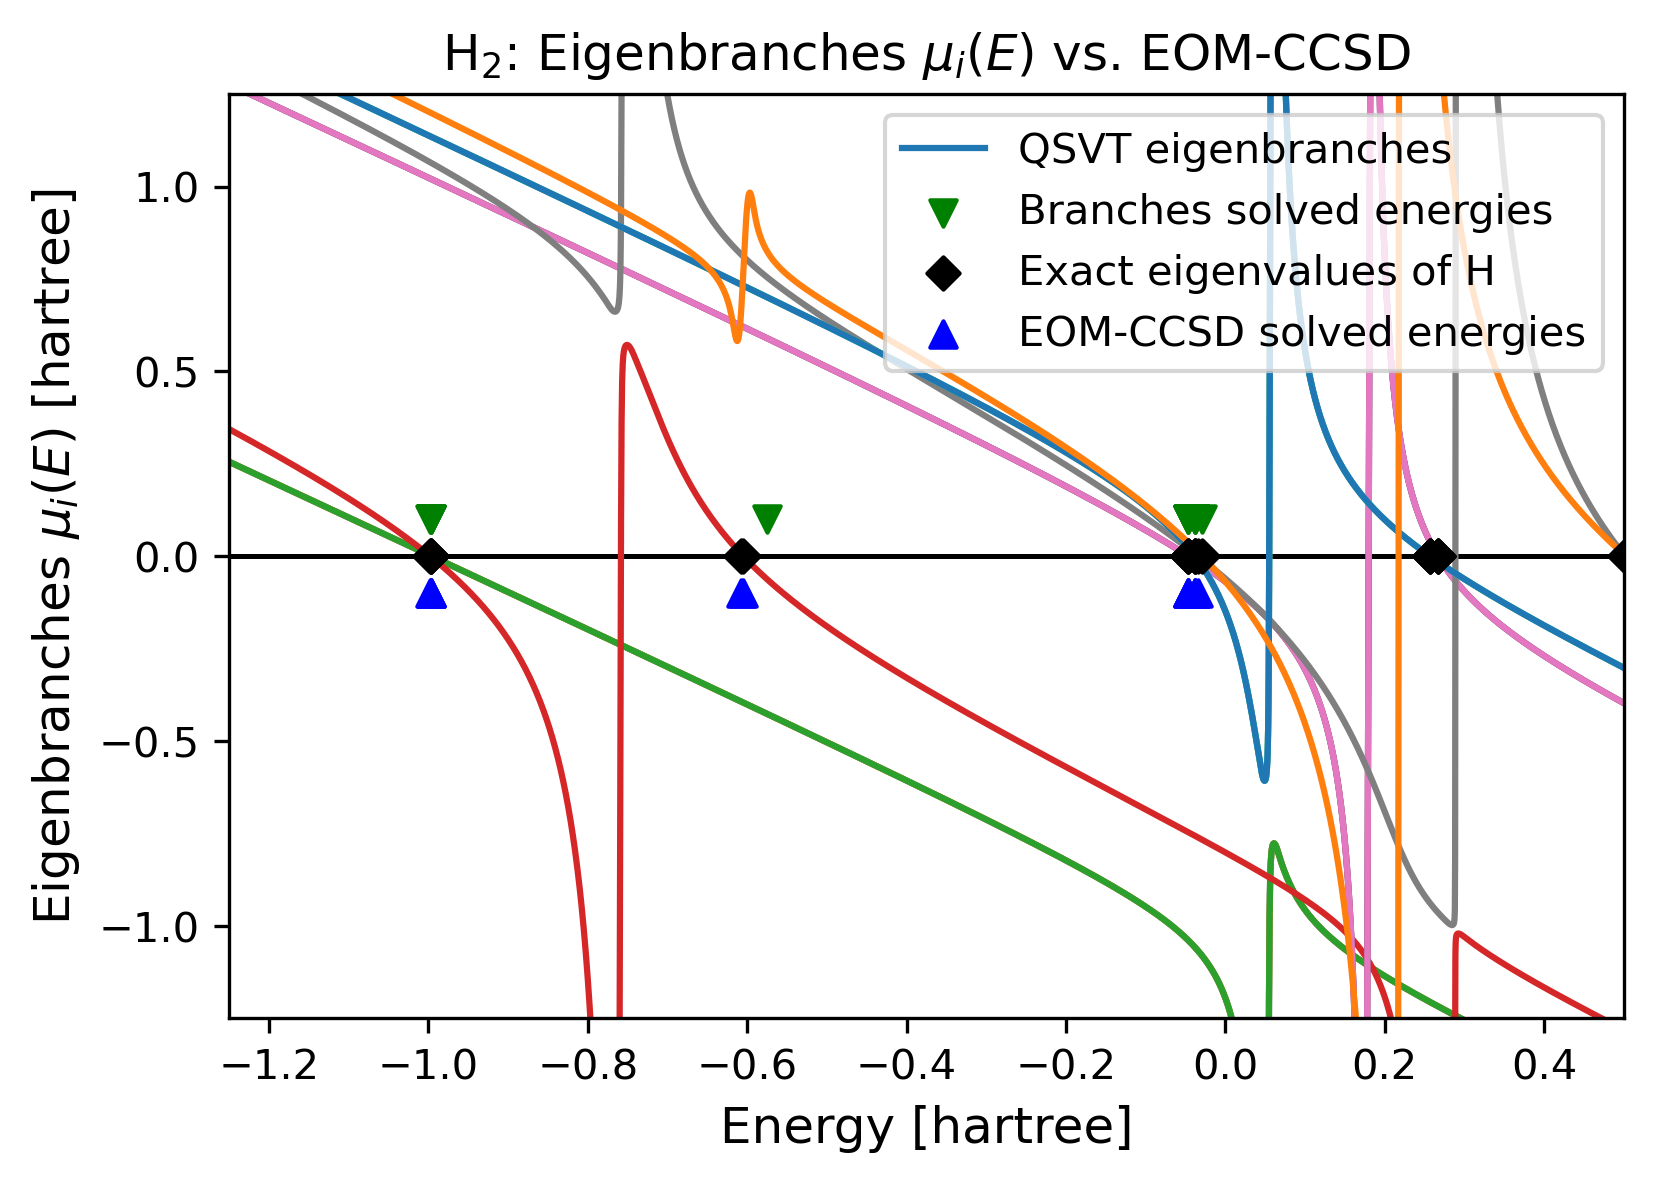

In [35]:
# 畫圖
plt.figure(figsize=(6, 4), dpi=300)  # 設定尺寸與解析度
plt.xlabel('Energy [hartree]', fontsize=12)
plt.ylabel(r'Eigenbranches $\mu_i(E)$ [hartree]', fontsize=12)
plt.xlim(-1.25, 0.5)
# plt.xlim(-0.2, 0.2)
plt.ylim(-1.25, 1.25)

# 畫基準線
plt.axhline(y=0, color='black', linewidth=1.2)
# plt.plot(Energy, -Energy+0.03, linewidth= 0.8, color='black', zorder=5)
# 畫 Eigenbranches
for i, Eigenbranch in enumerate(Last_Overlap_Eigenbranches):
    if(i==0):
        plt.plot(Energy, Eigenbranch, linewidth=1.5, label='QSVT eigenbranches')
    else:
        plt.plot(Energy, Eigenbranch, linewidth=1.5)

# 用散點標示結果 (三角形)
plt.scatter(solved_eigvals, np.zeros_like(solved_eigvals) + 0.1,  # 稍微上移 0.02 避免重疊
            color='green', marker='v', s=40, label='Branches solved energies', zorder=3)

# 畫本徵值
plt.scatter(H_eigvals, np.zeros_like(H_eigvals), color='black', marker='D', s=30, label='Exact eigenvalues of H', zorder=4)

plt.scatter(CCSD_eigvals, np.zeros_like(CCSD_eigvals) - 0.1,  # 稍微上移 0.02 避免重疊
            color='blue', marker='^', s=40, label='EOM-CCSD solved energies', zorder=2)

# plt.plot(QHQ_eigvals, np.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3, label='Eigenvalues of QHQ')
# 加入圖例
plt.legend(fontsize=10, loc='upper right', frameon=True)
# plt.axvline(x=(0.02397069198481956-0.6689522892245103)/2, color='black', linewidth=1.2)
# plt.axvline(x=0.02397069198481956, color='black', linewidth=1.2)
plt.title(r'H$_2$: Eigenbranches $\mu_i(E)$ vs. EOM-CCSD')

# 儲存高解析度圖片
# plt.savefig('H2_eigenbranches.png', dpi=300, bbox_inches='tight')
# 顯示圖表
plt.show()


In [40]:
H_eigvals

array([-0.99745483, -0.99597969, -0.99597969, -0.99597969, -0.60732453,
       -0.60480046, -0.04635358, -0.04635358, -0.04635358, -0.03821833,
       -0.03821833, -0.03821833, -0.03435989, -0.02918123,  0.25661562,
        0.25661562,  0.25661562,  0.26672639,  0.26672639,  0.26672639,
        0.5013429 ,  0.50220759,  0.92921256,  0.93550011,  0.93550011,
        0.93550011,  1.52755023,  1.54375384])

In [41]:
solved_eigvals

[-0.9974548510627725,
 -0.9959796912445307,
 -0.9959796912445306,
 -0.9959796912445302,
 -0.5756542421492761,
 -0.04635360304789313,
 -0.04635360304789242,
 -0.04635360304789206,
 -0.03821833205162509,
 -0.03821833205162395,
 -0.03821833205162177,
 -0.02918128115584557]